### Maestría en Ciudades Sostenibles

# Manejo y Análisis de Datos
***
## Aprendizaje no supervisado

Mateo Neira
***

## Clustering y Reducción de Dimensionalidad

**Objetivo:** Aplicar algoritmos de aprendizaje no supervisado para descubrir grupos (clusters) en los datos y para reducir la dimensionalidad con el fin de visualizarlos.

In [1]:
# 1. Importar Librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn para clustering y preprocesamiento
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

# Configuración de estilo
sns.set_theme(style="whitegrid")

## Crear un Dataset Simulado

Crearemos un dataset que sea un desafío para los algoritmos de clustering:
*   Tendrá algunos grupos esféricos fáciles de encontrar.
*   Tendrá un grupo con una forma no esférica (dos "lunas").
*   Tendrá puntos de ruido (outliers).

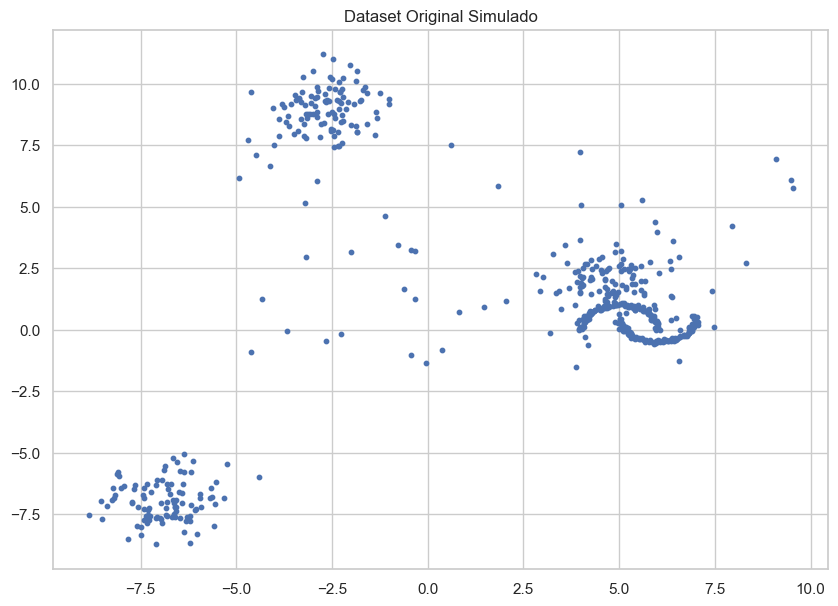

In [2]:
# Semilla para reproducibilidad
np.random.seed(42)

# Crear blobs (grupos esféricos)
X_blobs, y_blobs = make_blobs(n_samples=300, centers=3, cluster_std=0.8, random_state=42)

# Crear lunas (grupos no esféricos)
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=42)
X_moons = X_moons + np.array([5, 0]) # Mover las lunas a otra parte del espacio

# Crear ruido
X_noise = np.random.rand(50, 2) * np.array([15, 10]) - np.array([5, 2])

# Combinar todo en un solo dataset
X = np.vstack([X_blobs, X_moons, X_noise])

# Visualizar el dataset original
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Dataset Original Simulado")
plt.show()

### Escalado de Datos

Tanto K-Means como DBSCAN (y PCA) se basan en distancias, por lo que es fundamental escalar los datos para que todas las características tengan la misma importancia.

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Aprendizaje no supervisado - Agrupamiento K-means

#### Encontrar el `k` óptimo con el Método del Codo

Primero, intentamos determinar el número de clústeres (`k`) a buscar. Graficaremos la inercia para diferentes valores de `k`.

---

El algoritmo K-Means es un método común para agrupar datos, es decir, dividir un gran número de observaciones en grupos pequeños y discretos basados en ciertas características. El algoritmo de aprendizaje no supervisado intenta encontrar la mejor manera de categorizar las observaciones utilizando las características (variables) de estas observaciones que se le proporcionan. Sin embargo, es notable que este algoritmo requiere que el <b>número de clústeres</b> sea especificado por el analista.

Al crear grupos, el agrupamiento K-Means intenta crear grupos/clústeres que sean lo más homogéneos posible, pero lo más diferentes posible de todos los demás grupos/clústeres. Estos criterios se conocen más técnicamente como, respectivamente, "minimizar la suma de cuadrados dentro del clúster" y "maximizar la suma de cuadrados entre clústeres".

```
class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
```


c:\Users\mateo\miniconda3\envs\ciudades_sustentables\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\mateo\miniconda3\envs\ciudades_sustentables\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\mateo\miniconda3\envs\ciudades_sustentables\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is 

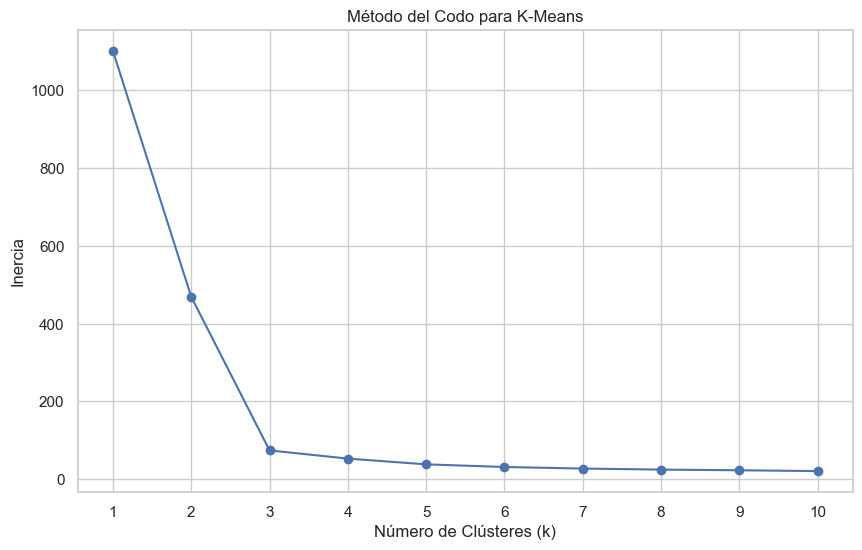

In [4]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.xticks(k_range)
plt.show()

El "codo" parece estar en `k=5`. Esto tiene sentido, ya que creamos 3 blobs y 2 lunas. Usemos este valor para entrenar nuestro modelo final.

### Entrenar y Visualizar K-Means

c:\Users\mateo\miniconda3\envs\ciudades_sustentables\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


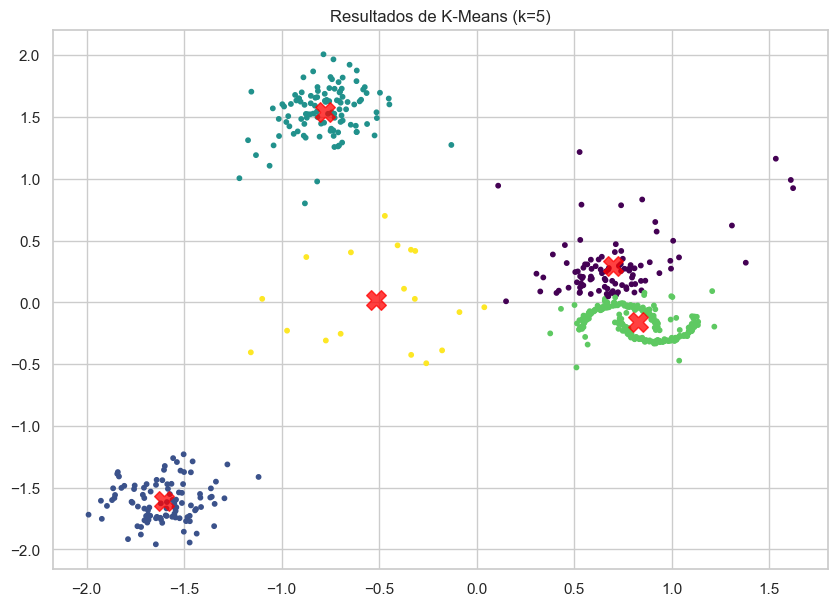

In [5]:
# Entrenar con k=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

# Visualizar los resultados
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, s=10, cmap='viridis')

# Visualizar los centroides
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('Resultados de K-Means (k=5)')
plt.show()

Observa cómo K-Means es bueno para encontrar los grupos esféricos (blobs), pero divide las lunas en dos clústeres separados porque intenta forzar una forma esférica. También asigna los puntos de ruido a algún clúster, no los identifica como outliers.

## Clustering con DBSCAN

DBSCAN no requiere que especifiquemos el número de clústeres. En su lugar, necesita dos parámetros: `eps` (el radio de vecindad) y `min_samples` (el número mínimo de puntos en esa vecindad). La elección de estos puede requerir algo de experimentación.

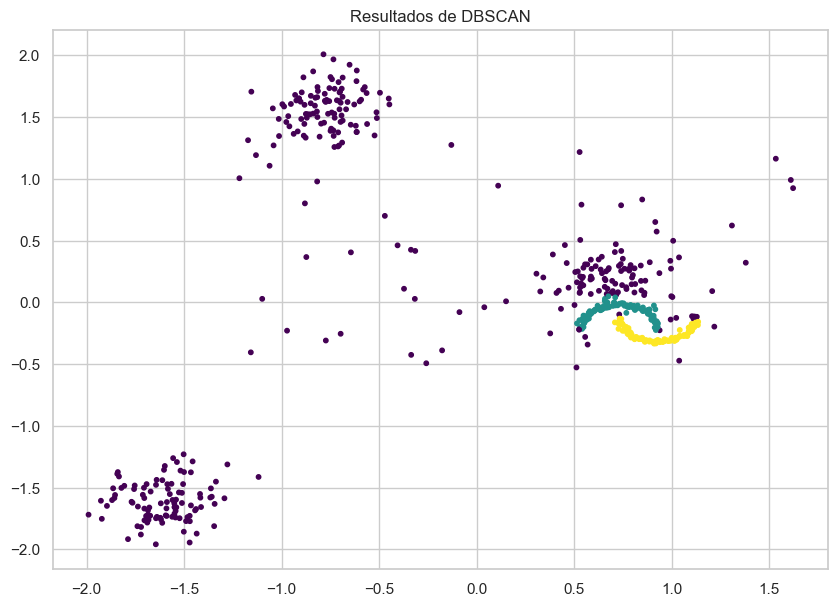

Número estimado de clústeres: 2
Número estimado de puntos de ruido: 347


In [35]:
# Entrenar DBSCAN
# Estos parámetros se eligieron después de un poco de experimentación
dbscan = DBSCAN(eps=0.05, min_samples=15)
y_dbscan = dbscan.fit_predict(X_scaled)

# Visualizar los resultados
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_dbscan, s=10, cmap='viridis')
plt.title('Resultados de DBSCAN')
plt.show()

# Contar el número de clústeres y puntos de ruido
n_clusters_ = len(set(y_dbscan)) - (1 if -1 in y_dbscan else 0)
n_noise_ = list(y_dbscan).count(-1)
print(f'Número estimado de clústeres: {n_clusters_}')
print(f'Número estimado de puntos de ruido: {n_noise_}')

Con estos parametros DBSCAN ha identificado correctamente a las 2 lunas como clústeres separados. Más importante aún, ha etiquetado los puntos de ruido con `-1` (mostrados en morado oscuro), reconociendo que no pertenecen a ningún grupo denso.

Explora que pasa si cambias los hiperparametros del modelo. Porque crees que no es posible agrupar los 2 blobs + las medias lunas?

---
### Reducción de Dimensionalidad con PCA

PCA es más útil cuando tenemos muchas más de 2 características, pero podemos usarlo aquí para demostrar el concepto. Reduciremos nuestras 2D a... 2D, pero el proceso es el mismo para dimensiones más altas. El objetivo es encontrar los ejes de máxima varianza.

Varianza explicada por cada componente: [0.60798583 0.39201417]
Varianza total explicada por 2 componentes: 1.00


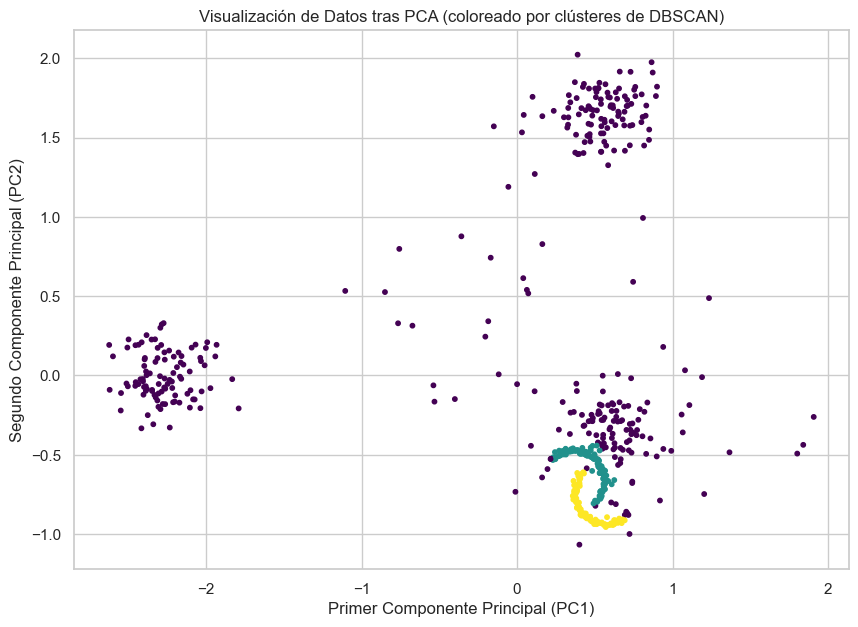

In [36]:
# Instanciar y ajustar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada por cada componente
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada por 2 componentes: {np.sum(pca.explained_variance_ratio_):.2f}")

# Visualizar los datos en el nuevo espacio de componentes principales
# Coloreamos los puntos según las etiquetas de DBSCAN para ver si la estructura se mantiene
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_dbscan, s=10, cmap='viridis')
plt.title('Visualización de Datos tras PCA (coloreado por clústeres de DBSCAN)')
plt.xlabel('Primer Componente Principal (PC1)')
plt.ylabel('Segundo Componente Principal (PC2)')
plt.show()

### Conclusión

*   **K-Means** es rápido y fácil de usar, pero asume que los clústeres son esféricos y no maneja bien los outliers. Es una excelente primera opción para una segmentación rápida.
*   **DBSCAN** es más potente, ya que puede encontrar clústeres de formas complejas e identificar ruido. Es ideal para datos espaciales o cuando se sospecha que hay outliers.
*   **PCA** es una herramienta indispensable para la reducción de dimensionalidad, especialmente útil para visualizar datos de alta dimensión y para preprocesar datos antes de alimentar otros algoritmos de machine learning.

Ejercicio de Laboratorio 5.2.2 : Datos del Censo del Reino Unido
-------------------------------

En este ejercicio, probaremos algunos de los métodos de aprendizaje automático que aprendimos anteriormente en un conjunto de datos del censo del Reino Unido. Este ejercicio le permitirá recapitular algunas de las funciones que aprendimos anteriormente, como fusionar marcos de datos y visualizar datos espaciales y no espaciales, así como implementar el nuevo contenido de esta semana. También se le anima a explorar más a fondo este conjunto de datos.

### 1. cargue la tabla csv como un marco de datos de pandas
fl = 'london-census-data.csv'

### 2. abra el shapefile como un geodataframe de geopandas
fp = "London_OA11_Shapfile/OA_2011_London_gen_MHW.shp"

### 3. fusione el geodataframe de geopandas con el marco de datos de pandas

### 4. cree un nuevo marco de datos con un subconjunto de variables para el agrupamiento.
"Age0to4", "Age15to17", "Age75", "Single", "WhiteBritish",
"WhiteOther", "Indian", "Pakistani","Chinese","Black",
"CoBoldEU","GoodVeryGoodHealth","LLTI","ManufactAndConstruct",
"Finance", "NoQual", "Level4Qual", "OwnedOutright","SocialRent",
"PrivateRent", "Student", "EmpAndMgr","LTUnemp"

### 5. cree una nueva función que estandarice X (z=x-mu/std)

### 6. repita con la función sklearn.standardise

### 7. ejecute el agrupamiento kmeans donde k=5

### 8. realice una visualización geográfica en geopandas donde k=5

### 9. Busque clústeres óptimos utilizando el método del codo

### 10. haga un mapa de calor para las medias de los clústeres de cada etiqueta y describa cada clúster.

In [57]:
import pandas as pd
from sklearn.cluster import KMeans

In [58]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

# 1. cargue la tabla csv como un marco de datos de pandas
fl = '../data/london-census-data.csv'
df=pd.read_csv(fl)


In [59]:
df.head()

,oacode,Male,Age0to4,Age5to9,Age10to14,Age15to17,Age20to24,Age25to29,Age30to59,Age65to74,...,HighProf,LowProf,Intermed,SmEmpSeEm,LowSuper,SemiRout,Routine,NeverWork,LTUnemp,Density
0,E00000001,53.608247,5.670103,1.546392,2.577320,2.577320,1.546392,7.216495,40.721649,13.402062,...,38.513514,31.081081,6.756757,8.783784,0.675676,1.351351,1.351351,0.675676,0.675676,6647.482593
1,E00000003,49.600000,5.600000,4.800000,2.000000,1.200000,4.000000,6.000000,51.600000,7.200000,...,43.216080,31.658291,5.025126,5.527638,1.005025,2.512563,0.502513,2.010050,0.502513,14600.887360
2,E00000005,53.133515,2.724796,3.269755,1.907357,0.544959,3.814714,10.081744,51.498638,8.991826,...,37.171053,36.513158,7.565789,5.592105,1.315789,1.973684,0.657895,0.657895,0.328947,8095.144199
3,E00000007,59.349593,4.065041,0.000000,3.252033,0.813008,11.382114,14.634146,60.162602,0.813008,...,37.837838,33.333333,9.009009,0.900901,0.900901,0.900901,0.900901,0.900901,0.900901,3672.931436
4,E00000010,58.823529,3.921569,0.980392,0.000000,0.000000,0.980392,11.764706,57.843137,6.862745,...,16.279070,33.720930,10.465116,6.976744,3.488372,6.976744,6.976744,5.813953,3.488372,7879.260213


In [60]:
# abrimos el shapefile como un geodataframe de geopandas
fp = "../data/London_OA11_Shapfile/OA_2011_London_gen_MHW.shp"
gdf=gpd.read_file(fp)


<Axes: >

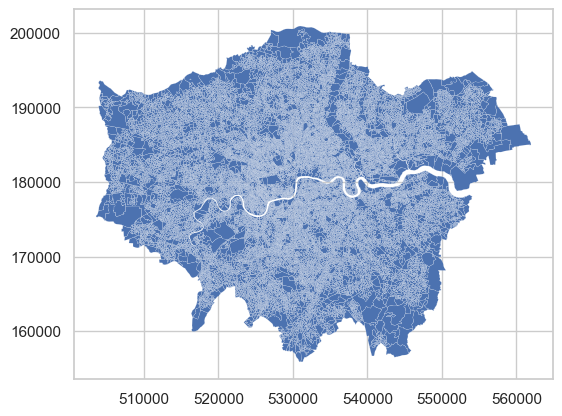

In [61]:
gdf.plot(linewidth=0.1)

In [62]:
# 3. fusione el geodataframe de geopandas con el marco de datos de pandas
gdf = pd.merge(left=gdf,right=df,left_on='OA11CD',right_on='oacode')
gdf.head()

,OA11CD,LSOA11CD,MSOA11CD,WD11CD_BF,WD11NM_BF,LAD11CD,LAD11NM,RGN11CD,RGN11NM,LSOA11NM,...,HighProf,LowProf,Intermed,SmEmpSeEm,LowSuper,SemiRout,Routine,NeverWork,LTUnemp,Density
0,E00023264,E01004612,E02000954,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 032C,...,9.722222,23.611110,10.277780,9.166667,3.611111,10.277780,4.722222,8.888889,1.111111,2127.364000
1,E00003359,E01000692,E02000128,E05000111,Chislehurst,E09000006,Bromley,E12000007,London,Bromley 002D,...,12.195122,30.243902,14.146341,7.317073,9.268293,5.853659,6.341463,2.926829,0.487805,5565.318764
2,E00023266,E01004615,E02000956,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 034B,...,4.591837,14.795920,10.204080,8.673469,5.102041,13.265310,12.755100,11.224490,2.551020,39.086670
3,E00020264,E01004027,E02000809,E05000548,Riverside,E09000028,Southwark,E12000007,London,Southwark 003E,...,15.692310,22.153850,10.769230,7.076923,4.923077,8.923077,7.076923,6.153846,1.538462,14243.470000
4,E00023263,E01004613,E02000955,E05000626,Tooting,E09000032,Wandsworth,E12000007,London,Wandsworth 033D,...,8.444444,22.222220,11.111110,6.222222,4.888889,14.222220,11.111110,8.444444,2.666667,7763.583000


<Axes: >

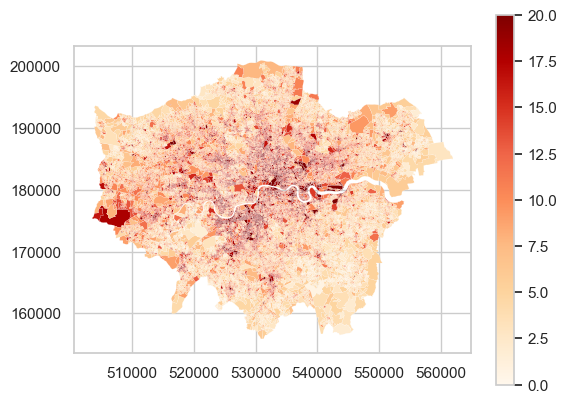

In [66]:
gdf.plot(column='Age25to29', 
         cmap='OrRd', 
         linewidth=0.1, 
         legend=True,
         vmin=0,
         vmax=20
         )

In [67]:
# cree un nuevo marco de datos con un subconjunto de variables para el agrupamiento. "Age0to4", "Age15to17", "Age75", "Single", "WhiteBritish",
#"WhiteOther", "Indian", "Pakistani","Chinese","Black",
#"CoBoldEU","GoodVeryGoodHealth","LLTI","ManufactAndConstruct",
#"Finance", "NoQual", "Level4Qual", "OwnedOutright","SocialRent",
#"PrivateRent", "Student", "EmpAndMgr","LTUnemp"

X=gdf[["Age0to4", "Age15to17", "Age75", "Single", "WhiteBritish",
"WhiteOther", "Indian", "Pakistani","Chinese","Black",
"CoBoldEU","GoodVeryGoodHealth","LLTI","ManufactAndConstruct",
"Finance", "NoQual", "Level4Qual", "OwnedOutright","SocialRent",
"PrivateRent", "Student", "EmpAndMgr","LTUnemp"]]


In [68]:
# cree una nueva función que estandarice X (z=x-mu/std)
def standardise(x):
    return (x-np.mean(x))/np.std(x)

i=0
while i<len(X.columns):
    X.iloc[:,i]=standardise(X.iloc[:,i])
    i=i+1


In [69]:
# repita con la función sklearn.standardise
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X2=gdf[["Age0to4", "Age15to17", "Age75", "Single", "WhiteBritish",
"WhiteOther", "Indian", "Pakistani","Chinese","Black",
"CoBoldEU","GoodVeryGoodHealth","LLTI","ManufactAndConstruct",
"Finance", "NoQual", "Level4Qual", "OwnedOutright","SocialRent",
"PrivateRent", "Student", "EmpAndMgr","LTUnemp"]]
#X2 = scaler.fit_transform(X2)
X2.loc[:,X2.columns] = scaler.fit_transform(X2[X2.columns])


C:\Users\mateo\AppData\Local\Temp\ipykernel_24380\4073222450.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2.loc[:,X2.columns] = scaler.fit_transform(X2[X2.columns])


In [70]:
k=5
k_means = KMeans(n_clusters=k, n_init=10)
k_means.fit(X)
km=k_means.fit_predict(X)

In [71]:
# 8. visualice el conjunto de datos en geopandas donde k=5
lab=[i for i in range(0,k,1)]
gdf['labels']=km
gdf['labels_color'] = pd.cut(gdf['labels'], bins=k,
                             labels=lab)


<Axes: >

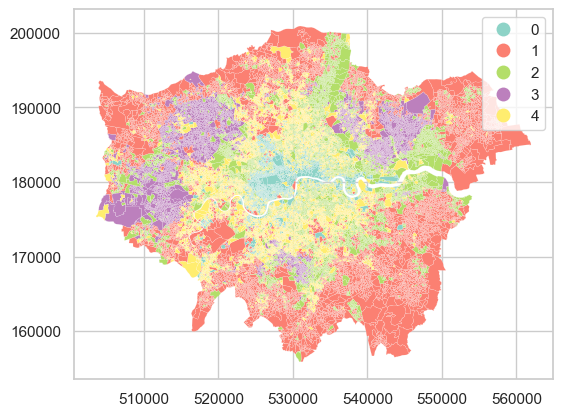

In [72]:
#plot the clusters
gdf.plot(column='labels_color',
            cmap='Set3',
            linewidth=0.1,
            legend=True
            )

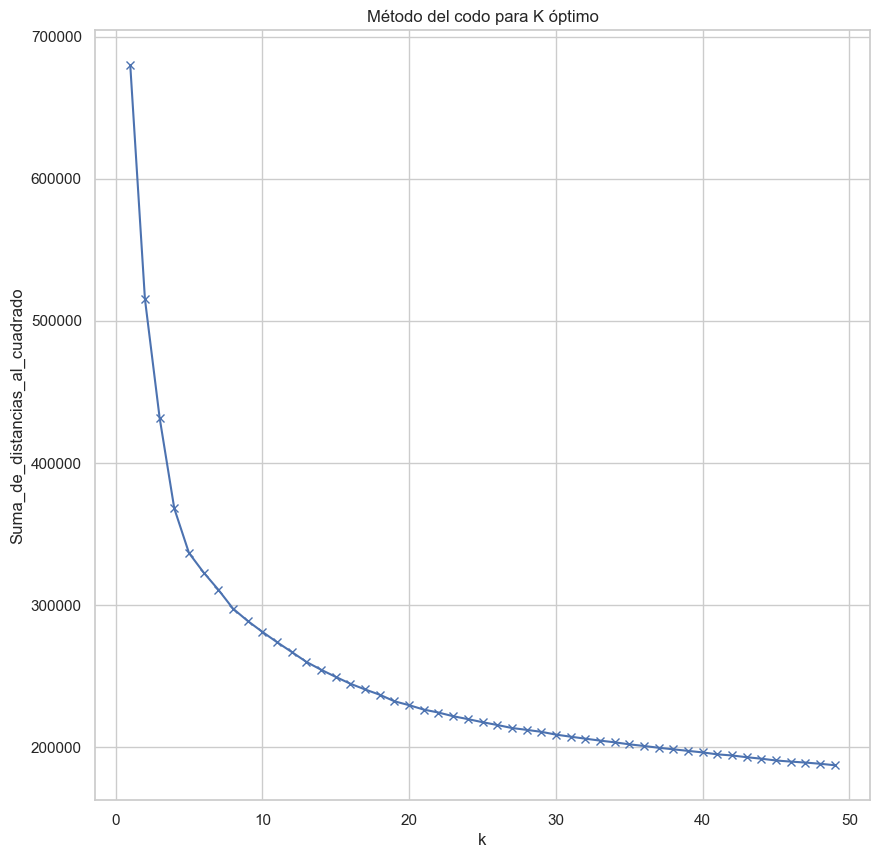

In [77]:
### Busque K óptimo usando el método del codo
### trazar la curva del codo para identificar el número de clústeres
Sum_of_squared_distances=[]
K=np.arange(1,50)
for i in K:
    kmeans=KMeans(n_clusters=i, n_init=10)
    kmeans=kmeans.fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.figure(figsize=(10,10))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Suma_de_distancias_al_cuadrado')
plt.title('Método del codo para K óptimo')
plt.show()


In [89]:
#utilizamos k=5
k_means = KMeans(n_clusters=5, n_init=10)

# primero ajuste kmeans en X
km=k_means.fit_predict(X)
# establezca la etiqueta de kmeans de nuevo en X
X['cluster_labels']=km

gdf['labels']=km
gdf['labels_color'] = pd.cut(gdf['labels'], bins=5,
                                labels=[0,1,2,3,4])

# nuevo marco de datos que toma la media de groupby(cluster) para sus características y transpone el marco de datos
newDF=X.groupby(by='cluster_labels').mean().T

C:\Users\mateo\AppData\Local\Temp\ipykernel_24380\353881983.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster_labels']=km


<Axes: >

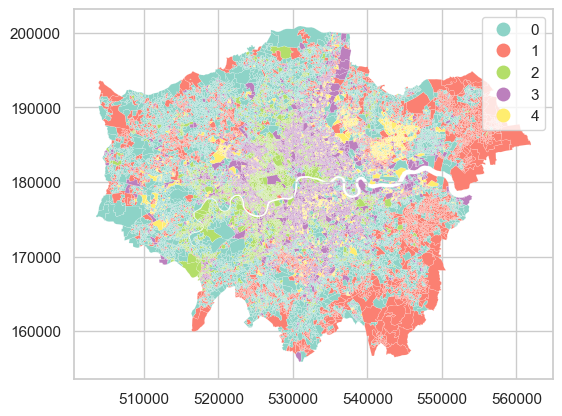

In [90]:
#visualicemos en el mapa de londres
gdf.plot(column='labels_color',
            cmap='Set3',
            linewidth=0.1,
            legend=True
            )

In [91]:
np.round(newDF,3)

cluster_labels,0,1,2,3,4
Age0to4,0.097,-0.299,-0.034,-0.189,0.738
Age15to17,0.209,0.359,-0.761,-0.270,0.647
Age75,0.041,0.785,-0.168,-0.209,-0.494
Single,-0.460,-0.873,0.219,0.819,0.154
WhiteBritish,0.167,0.471,0.389,-0.237,-1.140
WhiteOther,-0.214,-0.621,0.882,0.278,-0.425
Indian,0.360,0.131,-0.301,-0.365,0.118
Pakistani,0.003,0.165,-0.344,-0.283,1.046
Chinese,0.017,-0.309,0.248,0.083,-0.176
Black,-0.298,-0.288,-0.729,0.362,1.411


C:\Users\mateo\AppData\Local\Temp\ipykernel_24380\693635572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['labels']=km


Text(0.0, 1.0, 'Medias de los clústeres de Londres')

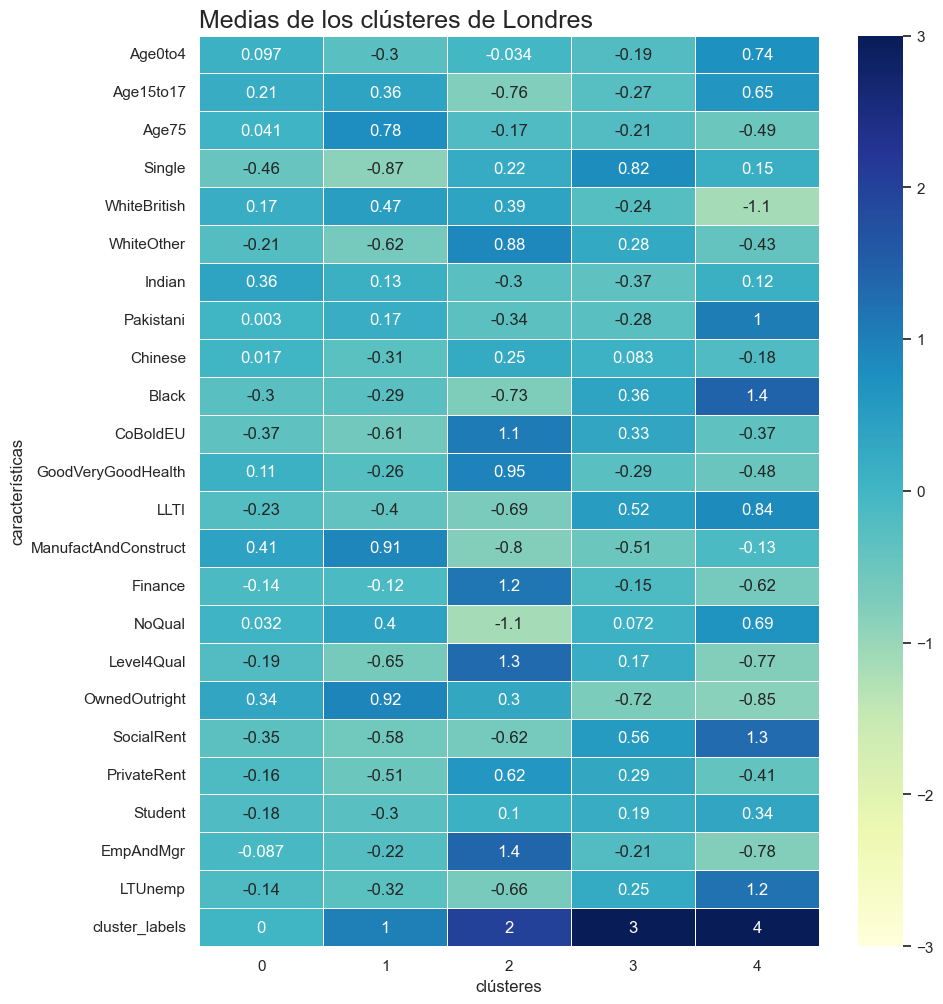

In [92]:
# haga un mapa de calor para las medias de los clústeres de cada etiqueta y describa cada clúster.
X['labels']=km
labelDf=X.groupby(by='labels').mean().T
import seaborn as sns
fig,ax=plt.subplots(1,figsize=(10,10))
sns.heatmap(labelDf, vmin=-3, vmax=3, annot=True,cmap="YlGnBu",linewidths=.5,ax=ax)
ax.set_ylabel('características')
ax.set_xlabel('clústeres')
fig.tight_layout()

plt.title('Medias de los clústeres de Londres', loc='left', fontsize=18)


# Ejercicio

Realiza un clustering con los datos censales de Cuenca